In [1]:
''' Paulo Simplício Braga
    05.07.2020
'''
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams["font.size"] = '12'
plt.rcParams['image.cmap'] = 'rainbow'
import seaborn as sns 

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import warnings
import tensorflow as tf
import keras
import os
seed = 6
import random as rn
rn.seed(seed)

np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
warnings.filterwarnings('ignore')

train_df = pd.read_csv('Data_Titanic/train.csv')

train_df.corr().style.background_gradient().set_precision(2)


/home/pbraga/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1,-0.005,-0.035,0.037,-0.058,-0.0017,0.013
Survived,-0.005,1,-0.34,-0.077,-0.035,0.082,0.26
Pclass,-0.035,-0.34,1,-0.37,0.083,0.018,-0.55
Age,0.037,-0.077,-0.37,1,-0.31,-0.19,0.096
SibSp,-0.058,-0.035,0.083,-0.31,1,0.41,0.16
Parch,-0.0017,0.082,0.018,-0.19,0.41,1,0.22
Fare,0.013,0.26,-0.55,0.096,0.16,0.22,1


I - Cálculo da % de valores faltantes por coluna:

In [2]:
total = train_df.isnull().sum().sort_values(ascending=False)
print(total)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64


In [3]:
pct_1 = train_df.isnull().sum()/train_df.isnull().count()*100
print(pct_1)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [4]:
pct_1 = round(pct_1, 1).sort_values(ascending=False)
print(pct_1)

Cabin          77.1
Age            19.9
Embarked        0.2
Fare            0.0
Ticket          0.0
Parch           0.0
SibSp           0.0
Sex             0.0
Name            0.0
Pclass          0.0
Survived        0.0
PassengerId     0.0
dtype: float64


In [5]:
dados_faltantes = pd.concat([total,pct_1], axis=1, keys=['Total', '%'])
dados_faltantes.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


II - Sobreviventes por sexo

In [6]:
# Quantidade por sexo
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Total')

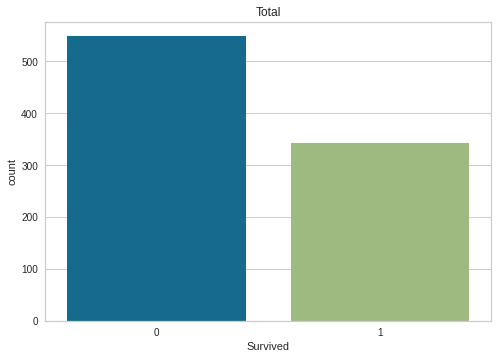

In [7]:
# Total de sobreviventes
sns.countplot(train_df['Survived']).set_title('Total')

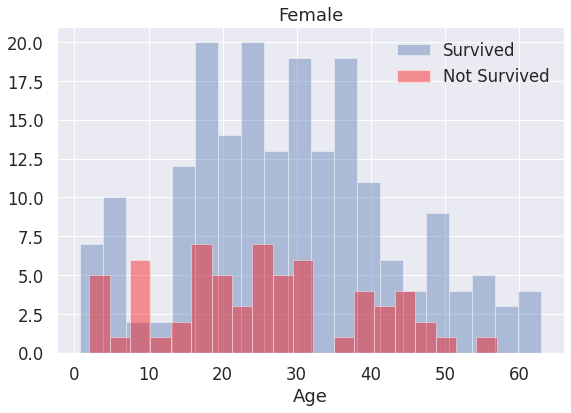

In [8]:
sns.set(font_scale=1.5)
fem = train_df[train_df['Sex']=='female'] # Cria um dataframe para female

# Cria um objeto 'fig' pra fazer o subplot
fig = plt.figure(figsize=(20,6))

# Adiciona o histograma 'Survived'
fig.add_subplot(1,2,1) # linhas, colunas, posição
to_plot = sns.distplot(fem[fem['Survived']==1].Age, bins=20, kde=False,\
                      label='Survived')
to_plot.set_title('Female')
to_plot.legend()

# Adiciona o histograma 'Not Survived'
fig.add_subplot(1,2,1) # linhas, colunas, posição
to_plot = sns.distplot(fem[fem['Survived']==0].Age, bins=20, kde=False,\
             color='red', label='Not Survived')
to_plot.legend()

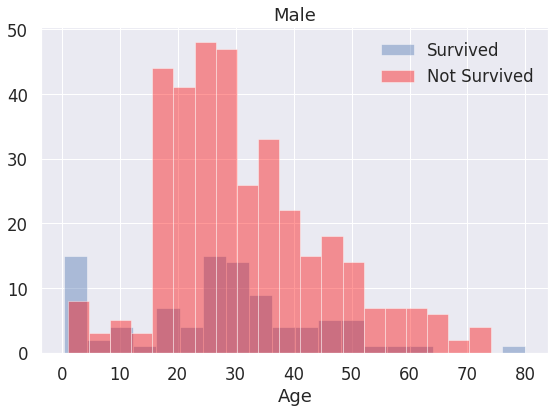

In [9]:
sns.set(font_scale=1.5)
male = train_df[train_df['Sex']=='male'] # Cria um dataframe para male

fig = plt.figure(figsize=(20,6))

fig.add_subplot(1,2,1)
to_plot = sns.distplot(male[male['Survived']==1].Age, bins=20, kde=False,\
                       label='Survived')
to_plot.set_title('Male')
to_plot.legend()

fig.add_subplot(1,2,1)
to_plot = sns.distplot(male[male['Survived']==0].Age, bins=20, kde=False,\
                      color='red', label='Not Survived')
to_plot.legend()


III - Relação da Sobrevivência com Classe Social e Porto de Embarque,
por gênero

Text(0.5, 1.0, 'Survived x Pclass')

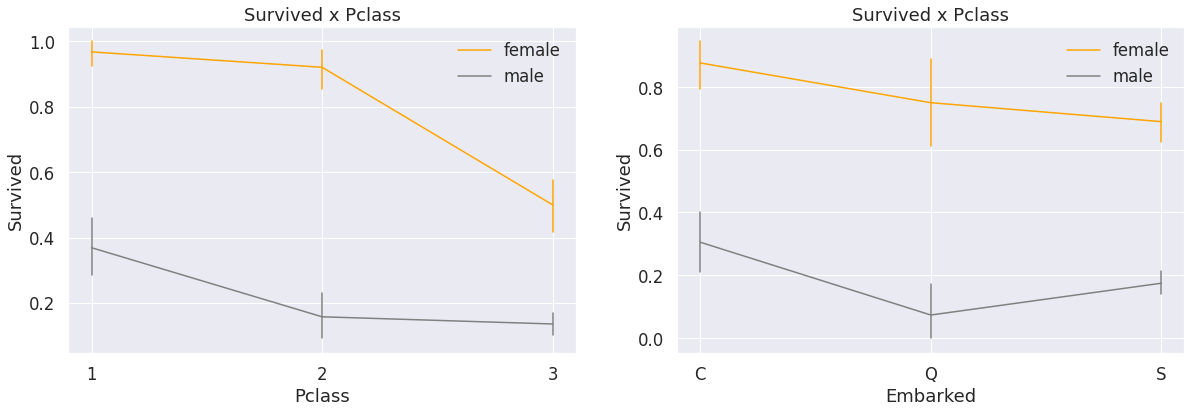

In [10]:
sns.set(font_scale=1.5)
fem = train_df[train_df['Sex']=='female'] # Cria um dataframe para female
male = train_df[train_df['Sex']=='male'] # Cria um dataframe para male

fig = plt.figure(figsize=(20,6))

# Pclass
fig.add_subplot(1,2,1)
to_plot = sns.lineplot('Pclass','Survived',data=fem,err_style="bars",\
                      label='female', color='orange')
fig.add_subplot(1,2,1)
to_plot = sns.lineplot('Pclass','Survived',data=male,err_style="bars",\
                      label='male', color='grey')
to_plot.set_title('Survived x Pclass')
to_plot.set(xticks=(np.arange(1, 4, 1)))

# Embarked
fig.add_subplot(1,2,2)
to_plot = sns.lineplot('Embarked','Survived',data=fem,err_style="bars",\
                      label='female', color='orange')
fig.add_subplot(1,2,2)
to_plot = sns.lineplot('Embarked','Survived',data=male,err_style="bars",\
                      label='male', color='grey')
to_plot.set_title('Survived x Pclass')

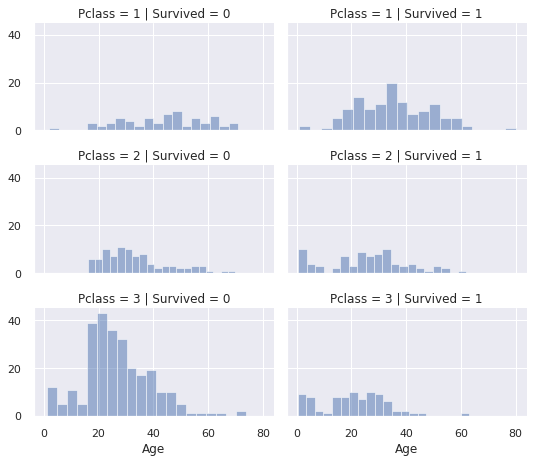

In [11]:
sns.set(font_scale=1.0)
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass',\
                     size=2.2, aspect=1.7)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

IV - Pré-Processamento dos dados

1. Imputation - Removendo colunas com menos de 70% de preenchimento e que possuem baixa ou nenhuma correlação com 'Survived'

In [12]:
# Remove features como mais de 70% de linhas nulas
limite = 0.7

train_df = train_df[train_df.columns[train_df.isnull().mean() < limite]]

# Remove Passenger ID, devido a baixa correlação com 'Survived'
train_df = train_df.drop(['PassengerId'], axis = 1)

# Remove Ticket, devido a baixa correlação com 'Survived'
train_df = train_df.drop(['Ticket'], axis = 1)

1.2 - Imputation em Age

In [13]:
num_cols = ['Pclass', 'SibSp', 'Parch', 'Fare']

# Cria o objeto knn para efetuar a imputação de valores baseado 
# no K-Nearest Neighbour (KNN)
knn = KNeighborsClassifier(3, weights='distance')

# Cria um data frame para treinamento do knn, excluindo os valores
# nulos
df_cc = train_df.dropna(axis=0)
df_cc['Age'] = df_cc['Age'].astype(int)

# Treina o modelo com 'Age' como 'target(y)'
model_3nn = knn.fit(df_cc.loc[:,num_cols],\
                    df_cc.loc[:,'Age'])
# Contabiliza a quantidade de nulos da feature 'Age'
missing_age = train_df['Age'].isnull()

# Cria um dataframe com as features 'X' (num_cols) com tamanho 
# igual ao número de valores nulos na feature 'Age'
df_missing_age = pd.DataFrame(train_df[num_cols][missing_age])

# Faz a previsão passando as features 'X', do data frame criado 
# na linha anterior
imputed_age = model_3nn.predict(df_missing_age)

# Preenche os valores nulos da feature 'Age', um por um, com os 
# valores previstos em 'imputed_age'
for i in imputed_age:
    train_df['Age'].fillna(i, inplace=True, limit=1)
train_df['Age'].isnull().sum()

0

1.3. Imputation em Embarked - Substituição pelo valor mais comum

In [14]:
# Demonstra que o valor mais comum é o 'S'
print(train_df['Embarked'].describe())
# Apenas dois valores nan
print("Quantidade de Nulos: ",train_df['Embarked'].isnull().sum())

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
Quantidade de Nulos:  2


In [15]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
print("Quantidade de Nulos: ",train_df['Embarked'].isnull().sum())

Quantidade de Nulos:  0


2. Outliers - Aplicando na feature 'Age'

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 <a list of 11 Text major ticklabel objects>)

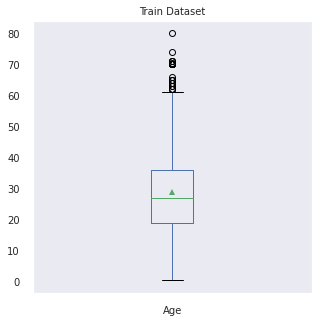

In [16]:
fig = plt.figure(figsize=(5,5))

# fig.add_subplot(1,2,1)
to_plot = train_df.boxplot(column='Age', grid=False, showmeans=True)
to_plot.set_title('Train Dataset', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [17]:
# Limites superior e inferior dos dataframes de treinamento e teste
def get_lim(df):
    Q1 = df['Age'].quantile(0.25)
    Q3 = df['Age'].quantile(0.75)
    lim_sup = Q3+(1.5*(Q3-Q1))
    lim_inf = Q1-(1.5*(Q3-Q1))
    print("quantile[0]:", train_df['Age'].quantile(0))
    if lim_inf < train_df['Age'].quantile(0):
        lim_inf = train_df['Age'].quantile(0)
    
    return lim_sup, lim_inf

lim_sup_train, lim_inf_train = get_lim(train_df)
print(lim_sup_train, lim_inf_train)

quantile[0]: 0.42
61.5 0.42


In [18]:
for i in train_df['Age']:
    if i < 0:
        print(i)

In [19]:
# Após definidos os limites, os outliers são removidos
train_df['Age'] = train_df['Age'].astype(int)
train_df = train_df[ (train_df['Age']<lim_sup_train) &\
                    (train_df['Age']>lim_inf_train) ]

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text major ticklabel objects>)

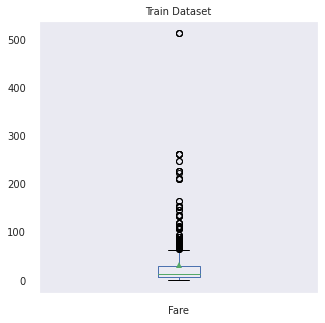

In [20]:
fig = plt.figure(figsize=(5,5))

# fig.add_subplot(1,2,1)
to_plot = train_df.boxplot(column='Fare', grid=False, showmeans=True)
to_plot.set_title('Train Dataset', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [21]:
# Limites superior e inferior dos dataframes de treinamento e teste
def get_lim(df):
    Q1 = df['Fare'].quantile(0.25)
    Q3 = df['Fare'].quantile(0.75)
    lim_sup = Q3+(1.5*(Q3-Q1))
    lim_inf = Q1-(1.5*(Q3-Q1))
    print("quantile[0]:", train_df['Fare'].quantile(0))
    if lim_inf < train_df['Fare'].quantile(0):
        lim_inf = train_df['Fare'].quantile(0)
    
    return lim_sup, lim_inf

lim_sup_train, lim_inf_train = get_lim(train_df)
print(lim_sup_train, lim_inf_train)

quantile[0]: 0.0
64.4063 0.0


In [22]:
# Após definidos os limites, os outliers são removidos
# train_df['Fare'] = train_df['Fare'].astype(int)
train_df = train_df[ (train_df['Fare']<lim_sup_train) &\
                    (train_df['Fare']>lim_inf_train) ]

3. Binning - Aplicando binning em 'Age' e 'Fare'

In [23]:
# Lista com os labels 
list_bin=[0, 1, 2, 3, 4, 5, 6]
# Função para aplicar o binning em Age e Fare, pois são os valores 
# que têm maior variação
def set_binning(feat):
    name_feat='bin_'+feat
    train_df[name_feat] = pd.qcut(train_df[feat], q= 7, \
                          labels=list_bin)#, duplicates='drop')
set_binning('Age')
set_binning('Fare')


4. Feature Split - Aplicação em 'Name'

In [24]:
# Verifica os titulos existentes
train_df['Name'].str.split(" ").map(lambda x: x[1]).unique()

array(['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Billiard,', 'der', 'Walle,', 'Pelsmaeker,', 'Mulder,', 'Dr.',
       'Steen,', 'Carlo,', 'Impe,', 'Ms.', 'Major.', 'y', 'Gordon,',
       'Messemaeker,', 'Col.', 'Mlle.', 'Velde,', 'Shawah,', 'Melkebeke,',
       'Cruyssen,'], dtype=object)

In [25]:
# Encontrando os títulos
train_df['Title'] = train_df['Name'].str.split(" ").map(lambda x: x[1])
# Substituindo
train_df['Title'] = train_df['Title'].replace(['Planke,', 'Don.', 'Rev.',\
            'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,',\
            'Mulder,', 'y','Steen,', 'Carlo,', 'Mme.', 'Impe,',\
            'Ms.', 'Major.', 'Gordon,','Messemaeker,', 'Mlle.',\
            'Col.', 'Velde,', 'the', 'Shawah,','Jonkheer.',\
            'Melkebeke,', 'Cruyssen,'], 'Other')                                          
# trata campos nulos
train_df['Title'] = train_df['Title'].fillna('Other')

# Remove a feature 'Name' após a criação de 'Title'
train_df = train_df.drop(['Name'], axis=1)

4. One Hot Encoding - Aplicando nas features Sex, Name e Embarked

In [26]:
# Aplicando One-Hot Encoding na feature Title, pois ela é categórica
enc_col = pd.get_dummies(train_df['Title'])
train_df = train_df.join(enc_col).drop('Title', axis=1)

In [27]:
# Aplicando One-Hot Encoding na feature Sex, pois ela é categórica
enc_col = pd.get_dummies(train_df['Sex'])
train_df = train_df.join(enc_col).drop('Sex', axis=1)

In [28]:
# Aplicando One-Hot Encoding na feature Embarked, pois ela é categórica
enc_col = pd.get_dummies(train_df['Embarked'])
train_df = train_df.join(enc_col).drop('Embarked', axis=1)

5. Convertendo para int

In [29]:
# # Antes de converter Fare para int, preenche os nulos com a média
mean = train_df['Fare'].mean()
train_df['Fare'] = train_df['Fare'].fillna(mean)
train_df['Fare'] = train_df['Fare'].astype(int)

train_df['bin_Age'] = train_df['bin_Age'].astype(int)

train_df['bin_Fare'] = train_df['bin_Fare'].astype(int)


6. Normalization

In [30]:
# Aplicando Normalization nas features com valores maiores que 1
feat_list = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'bin_Age',\
             'bin_Fare']
def normalize(feat, train_df):
    feat_name = 'norm_'+feat    
    train_df[feat_name] = (train_df[feat] - train_df[feat].min())/ \
                    (train_df[feat].max() - train_df[feat].min())
    train_df = train_df.drop(feat, axis=1)
    return train_df
for i in feat_list:
    train_df=normalize(i, train_df)

In [31]:
train_df = train_df.drop(['norm_Age'], axis = 1)
train_df = train_df.drop(['norm_Fare'], axis = 1)

V - Machine Learning Models

In [32]:
X = train_df.loc[:, train_df.columns != 'Survived'] # X recebe todas as
#, → colunas, exceto a coluna 'quality'
y = train_df.loc[:, train_df.columns == 'Survived'] # y recebe a coluna␣
#, → 'quality'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,\
shuffle = True, stratify = y)
model_list = ['Regressão Logística', 'Classificação Bayseana',\
'Árvore de Decisão', 'Random Forests', 'SVM', 'MLP']
resultados_acur = len(model_list)*[0]
map = {0:"died", 1:"survived"}

1. Regressão Logística

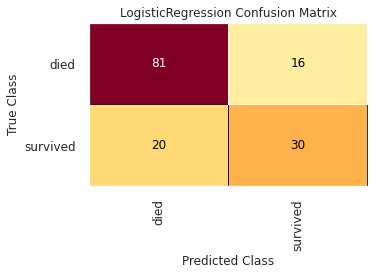

In [33]:
plt.subplots(figsize=(5,3))
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


cm_v = ConfusionMatrix(logreg, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[0] = cm_v.score(X_test, y_test)
cm_v.show()

In [34]:
print(resultados_acur[0])

0.7551020408163265


2. Classificação Bayseana

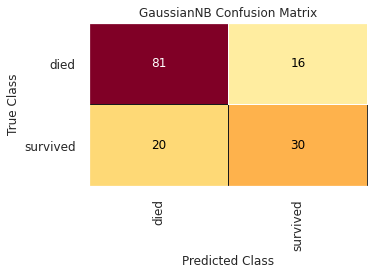

In [35]:
plt.subplots(figsize=(5,3))
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

cm_v = ConfusionMatrix(gaussian, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[1] = cm_v.score(X_test, y_test)
cm_v.show()

3. Árvore de Decisão

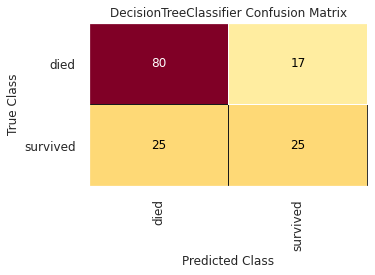

In [36]:
plt.subplots(figsize=(5,3))
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

cm_v = ConfusionMatrix(decision_tree, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[2] = cm_v.score(X_test, y_test)
cm_v.show()

4. Random Forests

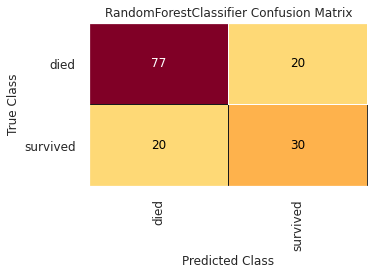

In [37]:
plt.subplots(figsize=(5,3))
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

cm_v = ConfusionMatrix(random_forest, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[3] = cm_v.score(X_test, y_test)
cm_v.show()

In [38]:
print(resultados_acur[3])

0.7278911564625851


5. Support Vector Machine

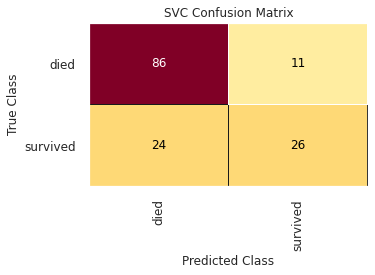

In [39]:
plt.subplots(figsize=(5,3))
svm_model = svm.SVC()#kernel='poly', gamma = 10, degree = 3)
svm_model.fit(X_train, y_train)

cm_v = ConfusionMatrix(svm_model, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[4] = cm_v.score(X_test, y_test)
cm_v.show()

In [40]:
resultados_acur[4]

0.7619047619047619

6. MLP

In [41]:
# Função para buscar os melhores valores, baseado na acurácia
def train_mlp_acc(in_p=17, hd_1=5, hd_2=5, output=2, activation='linear', optimizer='adam',\
              train_x=X_train, train_y=y_train, epochs=10):
    # Cria o objeto
    model = keras.models.Sequential()
    
    structure=[in_p,hd_1,hd_2,output]

    # Adiciona o layer de entrada mais o primeiro 'hidden layer'
    model.add(keras.layers.Dense(input_dim=structure[0],\
              units=structure[1], activation=activation))

    # Adiciona o segundo 'hidden layer'
    model.add(keras.layers.Dense(units=structure[2], activation=activation))

    # Adiciona o layer de 'output'
    model.add(keras.layers.Dense(units=structure[-1], activation=\
                                                     "softmax"))
    
    model.compile(loss = 'categorical_crossentropy',\
                  optimizer = optimizer, metrics = ['accuracy'])

    training_stats = model.fit(train_x, train_y, batch_size = 1,\
                               epochs = epochs, verbose = 0, shuffle = False)
    print('Training Evaluation: loss = %0.3f, accuracy = %0.2f%%'
          %(training_stats.history['loss'][-1], 100 * training_stats.\
                                             history['accuracy'][-1]))
    return (100 * training_stats.history['accuracy'][-1])
    

In [42]:
# one-hot encoding
labels=np.array(y_train['Survived'])
y_train = OneHotEncoder(sparse=False).fit_transform(np.transpose([labels]))
print(y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [43]:
X_train.shape

(588, 15)

In [44]:
# Escolhe o melhor valor para os 'hidden layers'
ret_struct = 3*[0]
max_acc = 0
for i in range(1,11):
    print("[hidden layers: %i] " %i, end='')
    acc = train_mlp_acc(in_p=15, hd_1=i, hd_2=i, train_y=y_train)
    if acc > max_acc:
        # Esta rotina grava o melhor valor de i para os 'hidden layers'
        ret_struct[0]=i;
        max_acc=acc

[hidden layers: 1] Training Evaluation: loss = 0.472, accuracy = 78.23%
[hidden layers: 2] Training Evaluation: loss = 0.450, accuracy = 79.42%
[hidden layers: 3] Training Evaluation: loss = 0.425, accuracy = 81.80%
[hidden layers: 4] Training Evaluation: loss = 0.422, accuracy = 82.48%
[hidden layers: 5] Training Evaluation: loss = 0.423, accuracy = 82.48%
[hidden layers: 6] Training Evaluation: loss = 0.424, accuracy = 82.48%
[hidden layers: 7] Training Evaluation: loss = 0.427, accuracy = 81.97%
[hidden layers: 8] Training Evaluation: loss = 0.426, accuracy = 82.65%
[hidden layers: 9] Training Evaluation: loss = 0.422, accuracy = 81.97%
[hidden layers: 10] Training Evaluation: loss = 0.424, accuracy = 82.65%


In [45]:
print("O melhor valor para os 'hidden layers' é:", ret_struct[0])

O melhor valor para os 'hidden layers' é: 8


In [46]:
# Aqui a melhor função de ativação será escolhida baseada em sua acurácia
activation_functions = ['elu', 'selu', 'relu', 'tanh', 'sigmoid', 
                        'hard_sigmoid', 'softplus', 'softsign', 'linear']
max_acc = 0
for activation in activation_functions:
    print("[%s] " %activation, end='')
    acc = train_mlp_acc(in_p=15, activation=activation, train_y=y_train)
    if acc > max_acc:
        # Esta rotina salva a função de ativação com melhor acurácia 
        ret_struct[1]=activation
        max_acc=acc

[elu] Training Evaluation: loss = 0.414, accuracy = 82.14%
[selu] Training Evaluation: loss = 0.415, accuracy = 82.14%
[relu] Training Evaluation: loss = 0.417, accuracy = 81.97%
[tanh] Training Evaluation: loss = 0.417, accuracy = 82.82%
[sigmoid] Training Evaluation: loss = 0.468, accuracy = 78.57%
[hard_sigmoid] Training Evaluation: loss = 0.462, accuracy = 78.57%
[softplus] Training Evaluation: loss = 0.432, accuracy = 81.80%
[softsign] Training Evaluation: loss = 0.421, accuracy = 81.12%
[linear] Training Evaluation: loss = 0.426, accuracy = 81.80%


In [47]:
print("A melhor função de ativação para o modelo é: ", ret_struct[1])

A melhor função de ativação para o modelo é:  tanh


In [48]:
optimization_functions = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta',
                          'Adam', 'Adamax', 'Nadam']
max_acc = 0
for optimizer in optimization_functions:
    print("[%s] " %optimizer, end='')
    acc= train_mlp_acc(in_p=15, optimizer=optimizer, train_y=y_train)
    if acc > max_acc:
        # Esta rotina salva a função de otimização com melhor acurácia 
        ret_struct[2]=optimizer
        max_acc=acc

[SGD] Training Evaluation: loss = 0.435, accuracy = 82.65%
[RMSprop] Training Evaluation: loss = 0.455, accuracy = 80.27%
[Adagrad] Training Evaluation: loss = 0.610, accuracy = 69.05%
[Adadelta] Training Evaluation: loss = 0.646, accuracy = 68.20%
[Adam] Training Evaluation: loss = 0.420, accuracy = 82.65%
[Adamax] Training Evaluation: loss = 0.459, accuracy = 78.06%
[Nadam] Training Evaluation: loss = 0.423, accuracy = 81.97%


In [49]:
print("O melhor otimizador para este modelo é:",ret_struct[2])

O melhor otimizador para este modelo é: SGD


In [50]:
# Função para treinar o modelo 
def train_mlp(model, in_p=17, hd_1=5, hd_2=5, output=2, activation='linear', optimizer='adam',\
              train_x=X_train, train_y=y_train, epochs=10):  
    # Adiciona o layer de entrada mais o primeiro 'hidden layer'
    model.add(keras.layers.Dense(input_dim=in_p,\
              units=hd_2, activation=activation))

    # Adiciona o segundo 'hidden layer'
    model.add(keras.layers.Dense(units=hd_2, activation=activation))

    # Adiciona o layer de 'output'
    model.add(keras.layers.Dense(units=output, activation="softmax"))
    
    model.compile(loss = 'categorical_crossentropy',\
                  optimizer = optimizer, metrics = ['accuracy'])

    training_stats = model.fit(train_x, train_y, batch_size = 1,\
                               epochs = epochs, verbose = 0, shuffle = False)
    print('Training Evaluation: loss = %0.3f, accuracy = %0.2f%%'
          %(training_stats.history['loss'][-1], 100 * training_stats.\
                                             history['accuracy'][-1]))
    return model

In [51]:
print(ret_struct)
model = keras.models.Sequential()

model = train_mlp(model,in_p=15, hd_1=ret_struct[0], hd_2=ret_struct[0], activation=ret_struct[1],\
                  optimizer=ret_struct[2], train_y=y_train)

[8, 'tanh', 'SGD']
Training Evaluation: loss = 0.417, accuracy = 82.65%


In [52]:
# one-hot encoding
labels=np.array(y_test['Survived'])
y_test = OneHotEncoder(sparse=False).fit_transform(np.transpose([labels]))

# Avalia o modelo com os dados dde teste
evaluation = model.evaluate(X_test,y_test, verbose=0)

print('Test Set Evaluation: loss = %0.6f, accuracy = %0.2f' %(evaluation[0], 100*evaluation[1]))

resultados_acur[5] = evaluation[1]

Test Set Evaluation: loss = 0.507305, accuracy = 79.59


7. Acurácia por Modelo

In [53]:
for i in range(len(resultados_acur)):
    print(model_list[i], ":", "{:.2f}".format(resultados_acur[i]*100),"%")

Regressão Logística : 75.51 %
Classificação Bayseana : 75.51 %
Árvore de Decisão : 71.43 %
Random Forests : 72.79 %
SVM : 76.19 %
MLP : 79.59 %
